In [1]:
import pandas as pd
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, prim
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy, Scenario)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench.util.utilities import (save_results, load_results)
import seaborn as sns
from SALib.analyze import sobol
import matplotlib.pyplot as plt


In [2]:
# get results from MORO
result_MORO = pd.read_csv('ANALYSIS_results/robust_results_10scenario_100nfe.csv')

In [3]:
# get policies
policies = result_MORO[['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]
policies_list = [Policy(str(index), **row.to_dict()) for index, row in policies.iterrows()]

In [4]:
# run model using sobol sampling
ema_logging.log_to_stderr(ema_logging.INFO)
model, functions = get_model_for_problem_formulation(2)

with MultiprocessingEvaluator(model) as evaluator:
    experiment, result = evaluator.perform_experiments(
                                         scenarios=100,
                                         policies = policies_list, 
                                         uncertainty_sampling='lhs')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 2 policies * 1 model(s) = 200 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
results = experiment, result
save_results(results, 'ANALYSIS_results/ANALYSIS_02_run_prim.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\flori\Primary\Documenten\EPA\Year 1\Q4\EPA1361 Model-based Decision-making\git\EPA1361\lab_sessions\final assignment\data\ANALYSIS_02_run_prim.tar.gz


In [17]:
experiment, results = load_results('ANALYSIS_results/ANALYSIS_02_run_prim.tar.gz')

[MainProcess/INFO] results loaded succesfully from c:\Users\flori\Primary\Documenten\EPA\Year 1\Q4\EPA1361 Model-based Decision-making\git\EPA1361\lab_sessions\final assignment\data\ANALYSIS_02_run_prim.tar.gz


In [18]:
# set up prim
x_prim = experiment[['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']]

y_prim = (result['Expected Number of Deaths'] > 0) | (result['Minimum water level full network'] < 4)

In [19]:
prim_alg = prim.Prim(x_prim, y_prim, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 200 points remaining, containing 124 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.11, coverage: 0.1774193548387097, density: 1.0 restricted_dimensions: 10


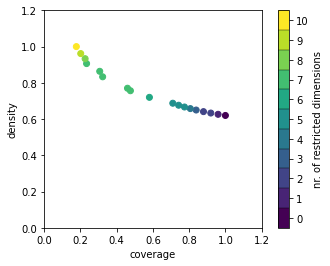

In [20]:
box1.show_tradeoff()
plt.show()

coverage    0.322581
density     0.833333
id                12
mass            0.24
mean        0.833333
res_dim            7
Name: 12, dtype: object

                                  box 12                   \
                                     min              max   
A.2_pfail                       0.002803         0.901081   
discount rate 0               {1.5, 3.5}       {1.5, 3.5}   
discount rate 2          {1.5, 3.5, 4.5}  {1.5, 3.5, 4.5}   
A.0_ID flood wave shape              6.5            131.0   
A.1_Bmax                        46.89711       333.232493   
A.5_Bmax                       71.454634        335.21442   
A.3_Bmax                       46.225051       347.423394   

                                                                     
                                                          qp values  
A.2_pfail                               [-1.0, 0.27206714889322114]  
discount rate 0                         [0.07563601982047755, -1.0]  
discount rate 2    

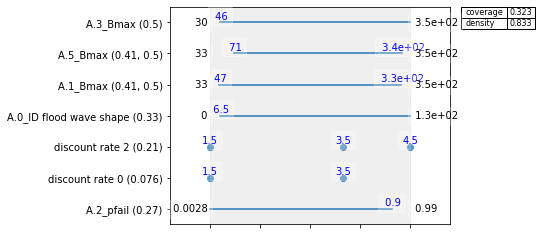

In [21]:
box1.inspect(12)
box1.inspect(12, style='graph')
plt.show()

In [22]:
# select box with making trade-off
box1.select(12)

In [31]:
# get scenarios and outcomes with selected box
scenarios = experiment.iloc[box1.yi]
outcome = {k:v[box1.yi] for k,v in result.items()}

In [32]:
# select two scenarios, one with the most expected deaths and one with the highest water level
scenarios_selection = [Scenario('deaths'), ]

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Minimum water level full network
0,3.844618e+08,6.795466e+08,0.0,0.000000,0.258828,4.538500
1,1.683866e+08,6.795466e+08,0.0,0.000000,0.182512,4.538500
2,1.383222e+08,6.795466e+08,0.0,0.000000,0.091906,4.538500
3,7.695720e+07,6.795466e+08,0.0,0.000000,0.058178,4.538500
4,3.121493e+07,6.795466e+08,0.0,0.000000,0.061972,5.078964
5,4.848257e+07,6.795466e+08,0.0,0.000000,0.054733,4.538500
6,3.956047e+07,6.795466e+08,0.0,0.000000,0.044063,4.538500
7,2.986231e+08,6.795466e+08,0.0,0.000000,0.314415,4.538500
8,1.951936e+08,6.795466e+08,0.0,0.000000,0.130575,4.538349
9,4.125359e+08,6.795466e+08,0.0,0.000000,0.856374,4.538500


In [ ]:
# apply MORDM to discover policies that per